In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# view the columns in each table within the database
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

# Exploratory Climate Analysis

In [64]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d').date()

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(most_recent_date.year,most_recent_date.month,most_recent_date.day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
latest_y_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
latest_y_prcp_df = pd.DataFrame(latest_y_prcp, columns=("date","precipitation"))

# Sort the dataframe by date
latest_y_prcp_df = latest_y_prcp_df.sort_values('date')
latest_y_prcp_df.head(10)

,date,precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
1881,2016-08-23,0.70
1192,2016-08-23,0.02
1,2016-08-24,0.08
1530,2016-08-24,2.15
705,2016-08-24,2.28


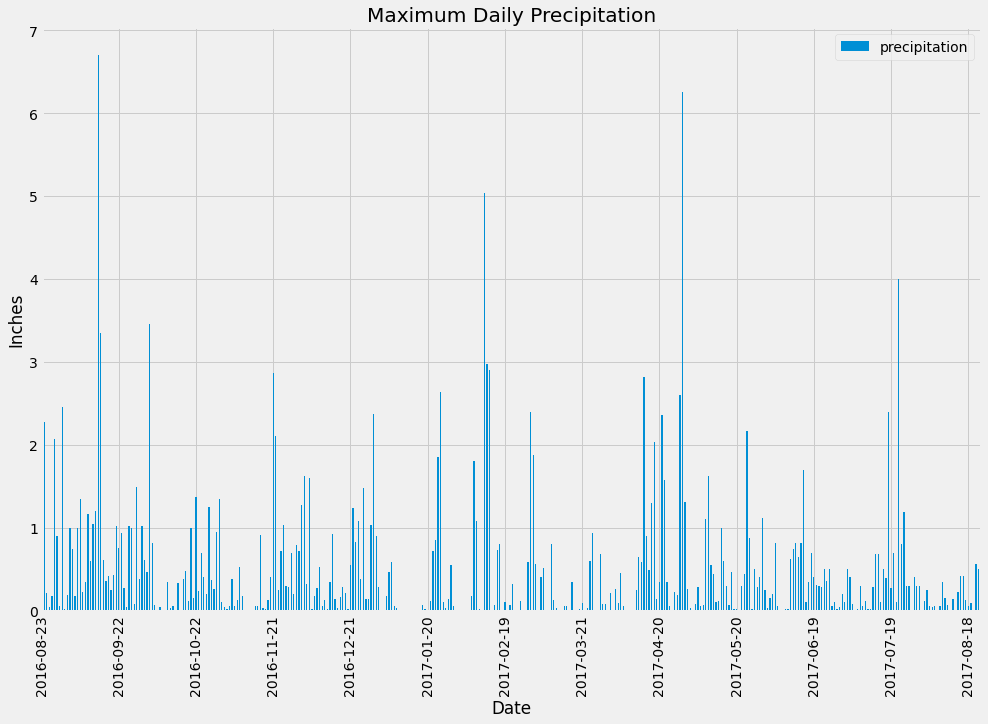

In [65]:
# Use Pandas Plotting with Matplotlib to plot the data
daily_pcpt = latest_y_prcp_df.groupby(['date']).max() # max precip recorded per day among all stations
daily_pcpt.plot(kind='bar', figsize = (15,10))
x_axis = np.arange(0,len(daily_pcpt.precipitation))
tick_location = np.arange(0,len(x_axis),int(len(x_axis)/12))
tick_label = [list(latest_y_prcp_df['date'].unique())[x] for x in tick_location]
plt.xticks(tick_location,tick_label,rotation='vertical')
plt.xlabel('Date')
plt.ylabel("Inches")
plt.title("Maximum Daily Precipitation")
plt.xlim(0,max(x_axis))
plt.show()

In [66]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = latest_y_prcp_df.groupby(['date']).agg({'precipitation':['min','max','mean','median','var','std','sem']})
summary_stats

precipitation                                                     
                     min   max      mean median       var       std       sem
date                                                                         
2016-08-23          0.00  1.79  0.451667  0.100  0.499097  0.706468  0.288414
2016-08-24          0.08  2.28  1.555000  1.800  0.706510  0.840541  0.343150
2016-08-25          0.00  0.21  0.077143  0.080  0.005157  0.071813  0.027143
2016-08-26          0.00  0.04  0.016667  0.015  0.000267  0.016330  0.006667
2016-08-27          0.00  0.18  0.064000  0.020  0.006680  0.081731  0.036551
...                  ...   ...       ...    ...       ...       ...       ...
2017-08-19          0.00  0.09  0.030000  0.000  0.002700  0.051962  0.030000
2017-08-20          0.00  0.01  0.005000  0.005  0.000050  0.007071  0.005000
2017-08-21          0.00  0.56  0.193333  0.020  0.100933  0.317700  0.183424
2017-08-22          0.00  0.50  0.166667  0.000  0.083333  0.288675  0.166667
2017-08-23          0.00  0.45  0.132500  0.040  0.046225  0.215000  0.107500

[366 rows x 7 columns]

In [72]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Station.id)).all()
print(f'There are {num_stations[0][0]} stations in this dataset')

There are 9 stations in this dataset


In [68]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,Station.name,func.count(Measurement.station)]
station_activity = session.query(*sel).\
                            filter(Station.station == Measurement.station).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc())
station_activity.all()

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [86]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = station_activity.first()[0]

min_temp = session.query(Station.name,func.min(Measurement.tobs)).\
                        filter(Measurement.station==most_active_station).all()

max_temp = session.query(Station.name,func.max(Measurement.tobs)).\
                        filter(Measurement.station==most_active_station).all()

avg_temp = session.query(Station.name,func.avg(Measurement.tobs)).\
                        filter(Measurement.station==most_active_station).all()

print(f'The most active station during last year was: {min_temp[0][0]}')
print(f'The minimum temperature recorded at this station was {min_temp[0][1]}F')
print(f'The maximum temperature recorded at this station was {max_temp[0][1]}F')
print(f'And, the average temperature recorded at this station was {round(avg_temp[0][1],0)}F')

The most active station during last year was: WAIKIKI 717.2, HI US
The minimum temperature recorded at this station was 54.0F
The maximum temperature recorded at this station was 85.0F
And, the average temperature recorded at this station was 72.0F


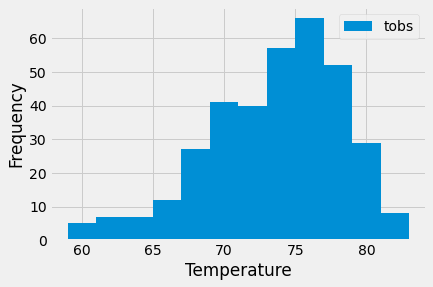

In [70]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_active_station = session.query(Measurement.date,Measurement.station,Measurement.tobs).\
                            filter(Measurement.station == most_active_station).\
                            filter(Measurement.date > one_year_ago).all()
temps = pd.DataFrame(temp_active_station, columns=("Date","Station","Temperature"))

plt.hist(temps["Temperature"],bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

## Bonus Challenge Assignment

In [88]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [110]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacay_start = '2017-02-28'
vacay_end = '2017-03-16'
vacay_temps = calc_temps(vacay_start, vacay_end)
vacay_temps

[(62.0, 71.19811320754717, 82.0)]

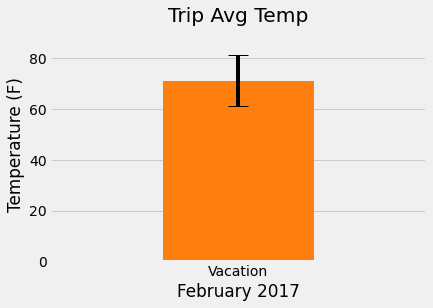

In [154]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tick_location = np.arange(2)
tick_label = ["","Vacation",""]
plt.bar(1,vacay_temps[0][1],facecolor="tab:orange",yerr=(((vacay_temps[0][2])-(vacay_temps[0][0]))/2),capsize=10)
plt.xlim(0,2)
plt.ylim(0,(vacay_temps[0][2])+10)
plt.xlabel('February 2017')
plt.ylabel("Temperature (F)")
plt.title("Trip Avg Temp")
plt.xticks(tick_location,tick_label)
plt.grid(b=None, which='both', axis='x')
plt.show()

In [229]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
select = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
vacay_prcp_station = session.query(*select).\
                            filter(Station.station == Measurement.station).\
                            filter(Measurement.date >= vacay_start).\
                            filter(Measurement.date <= vacay_end).\
                            group_by(Station.station).\
                            order_by(func.sum(Measurement.prcp).desc()).all()
vacay_prcp_station

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.92),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  5.500000000000001),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.08),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 3.04),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  2.7399999999999998),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.32),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.79)]

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
